
Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.



In [ ]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import PIL
import skimage
import albumentations

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from keras.models import *
from keras.layers import *
from keras.optimizers import *

print('슝=3')

슝=3


 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예입니다. imgaug의 Sometimes()와 유사한 기능입니다.

In [ ]:

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

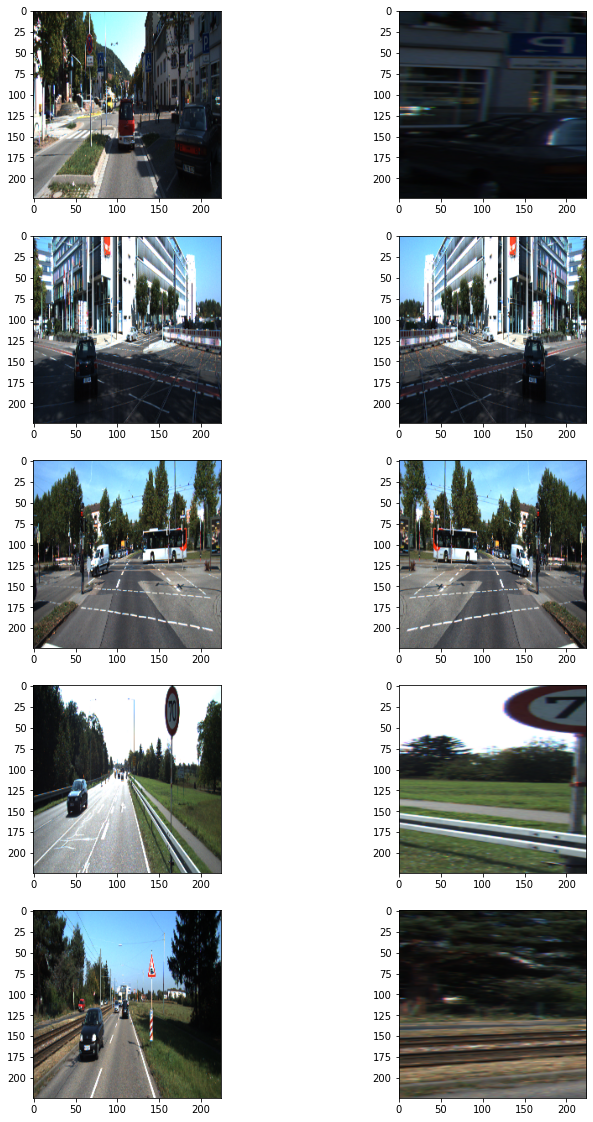

In [ ]:
dir_path = '/content/drive/MyDrive/aiffel/going10/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [ ]:
# tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보겠습니다.
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 구조 만들기

시맨틱 세그멘테이션을 위한 모델을 만들어주세요. 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해 봅시다.

이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어주세요.

사용에 필요한 레이어와 연산은 다음과 같습니다. 그리고 필요에 따라서 Dropout 등의 다른 레이어를 적용해 보세요.

**Conv2D, Conv2DTranspose, MaxPooling2D, concatenate**

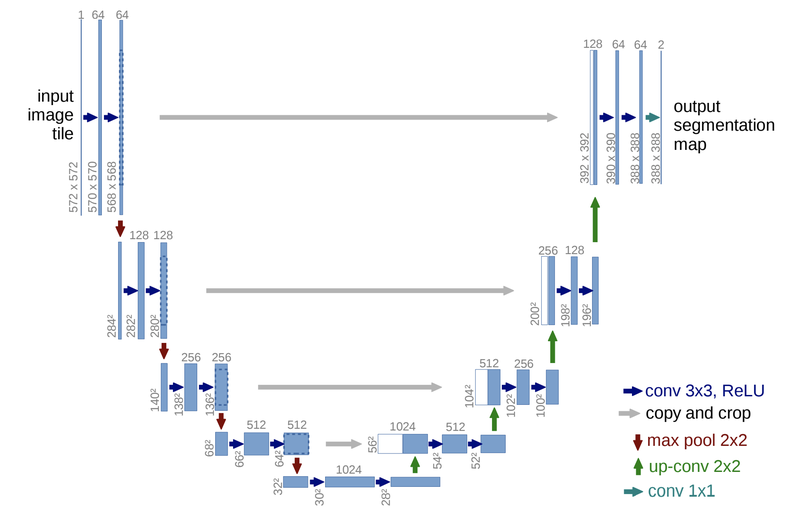

In [ ]:
def Unet_build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)  # U-Net에서는 '채널로 추가'한다는 의미로 Merge를 한다.
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
u_model = Unet_build_model()
u_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

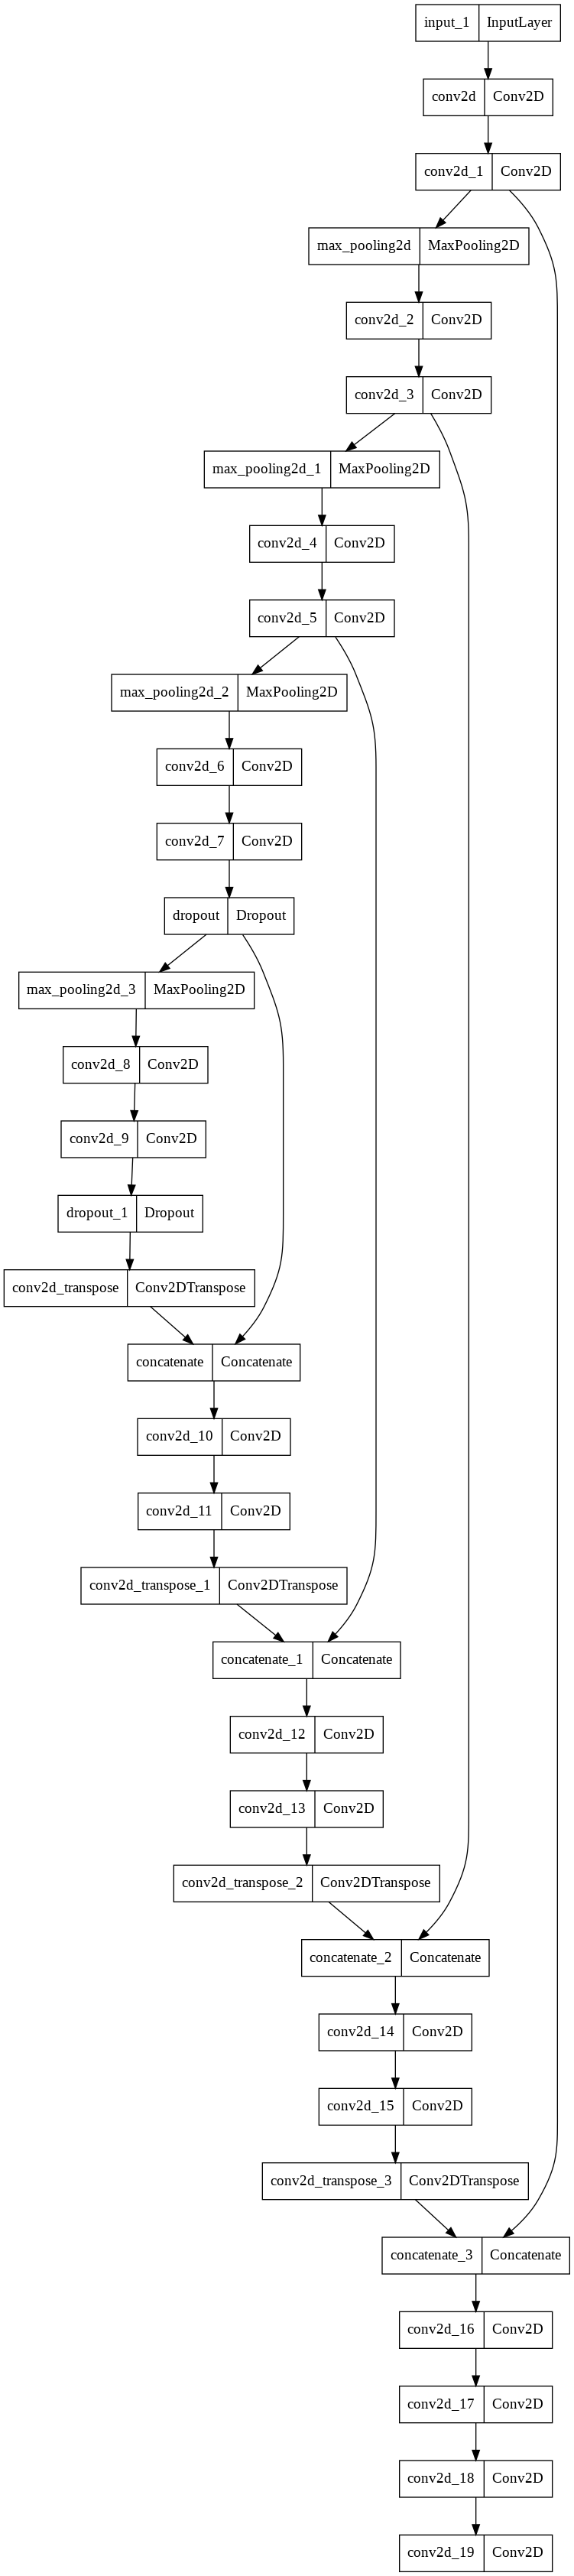

In [ ]:
tf.keras.utils.plot_model(u_model, to_file='./u_model.png')

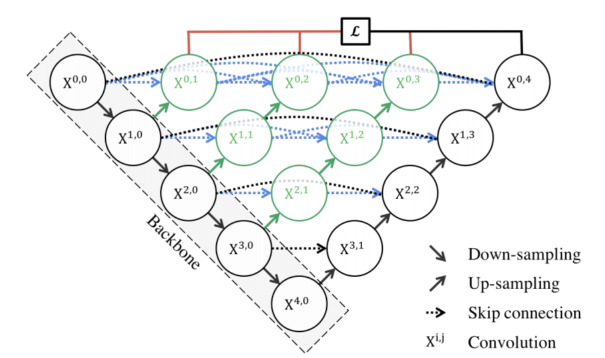

* up_block 방식: Transpose2D_block 과 Upsample2D_block 중 하나 사용
* Loss = binary cross-entropy + dice coefficient
* Deep Supervision : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법

In [ ]:
def Upp_build_model(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # X0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
   # deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1, output2, output3, output4])
    else:
        model = Model(inputs=inputs, outputs=output4)

    return model

In [ ]:
upp_model = Upp_build_model()
upp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

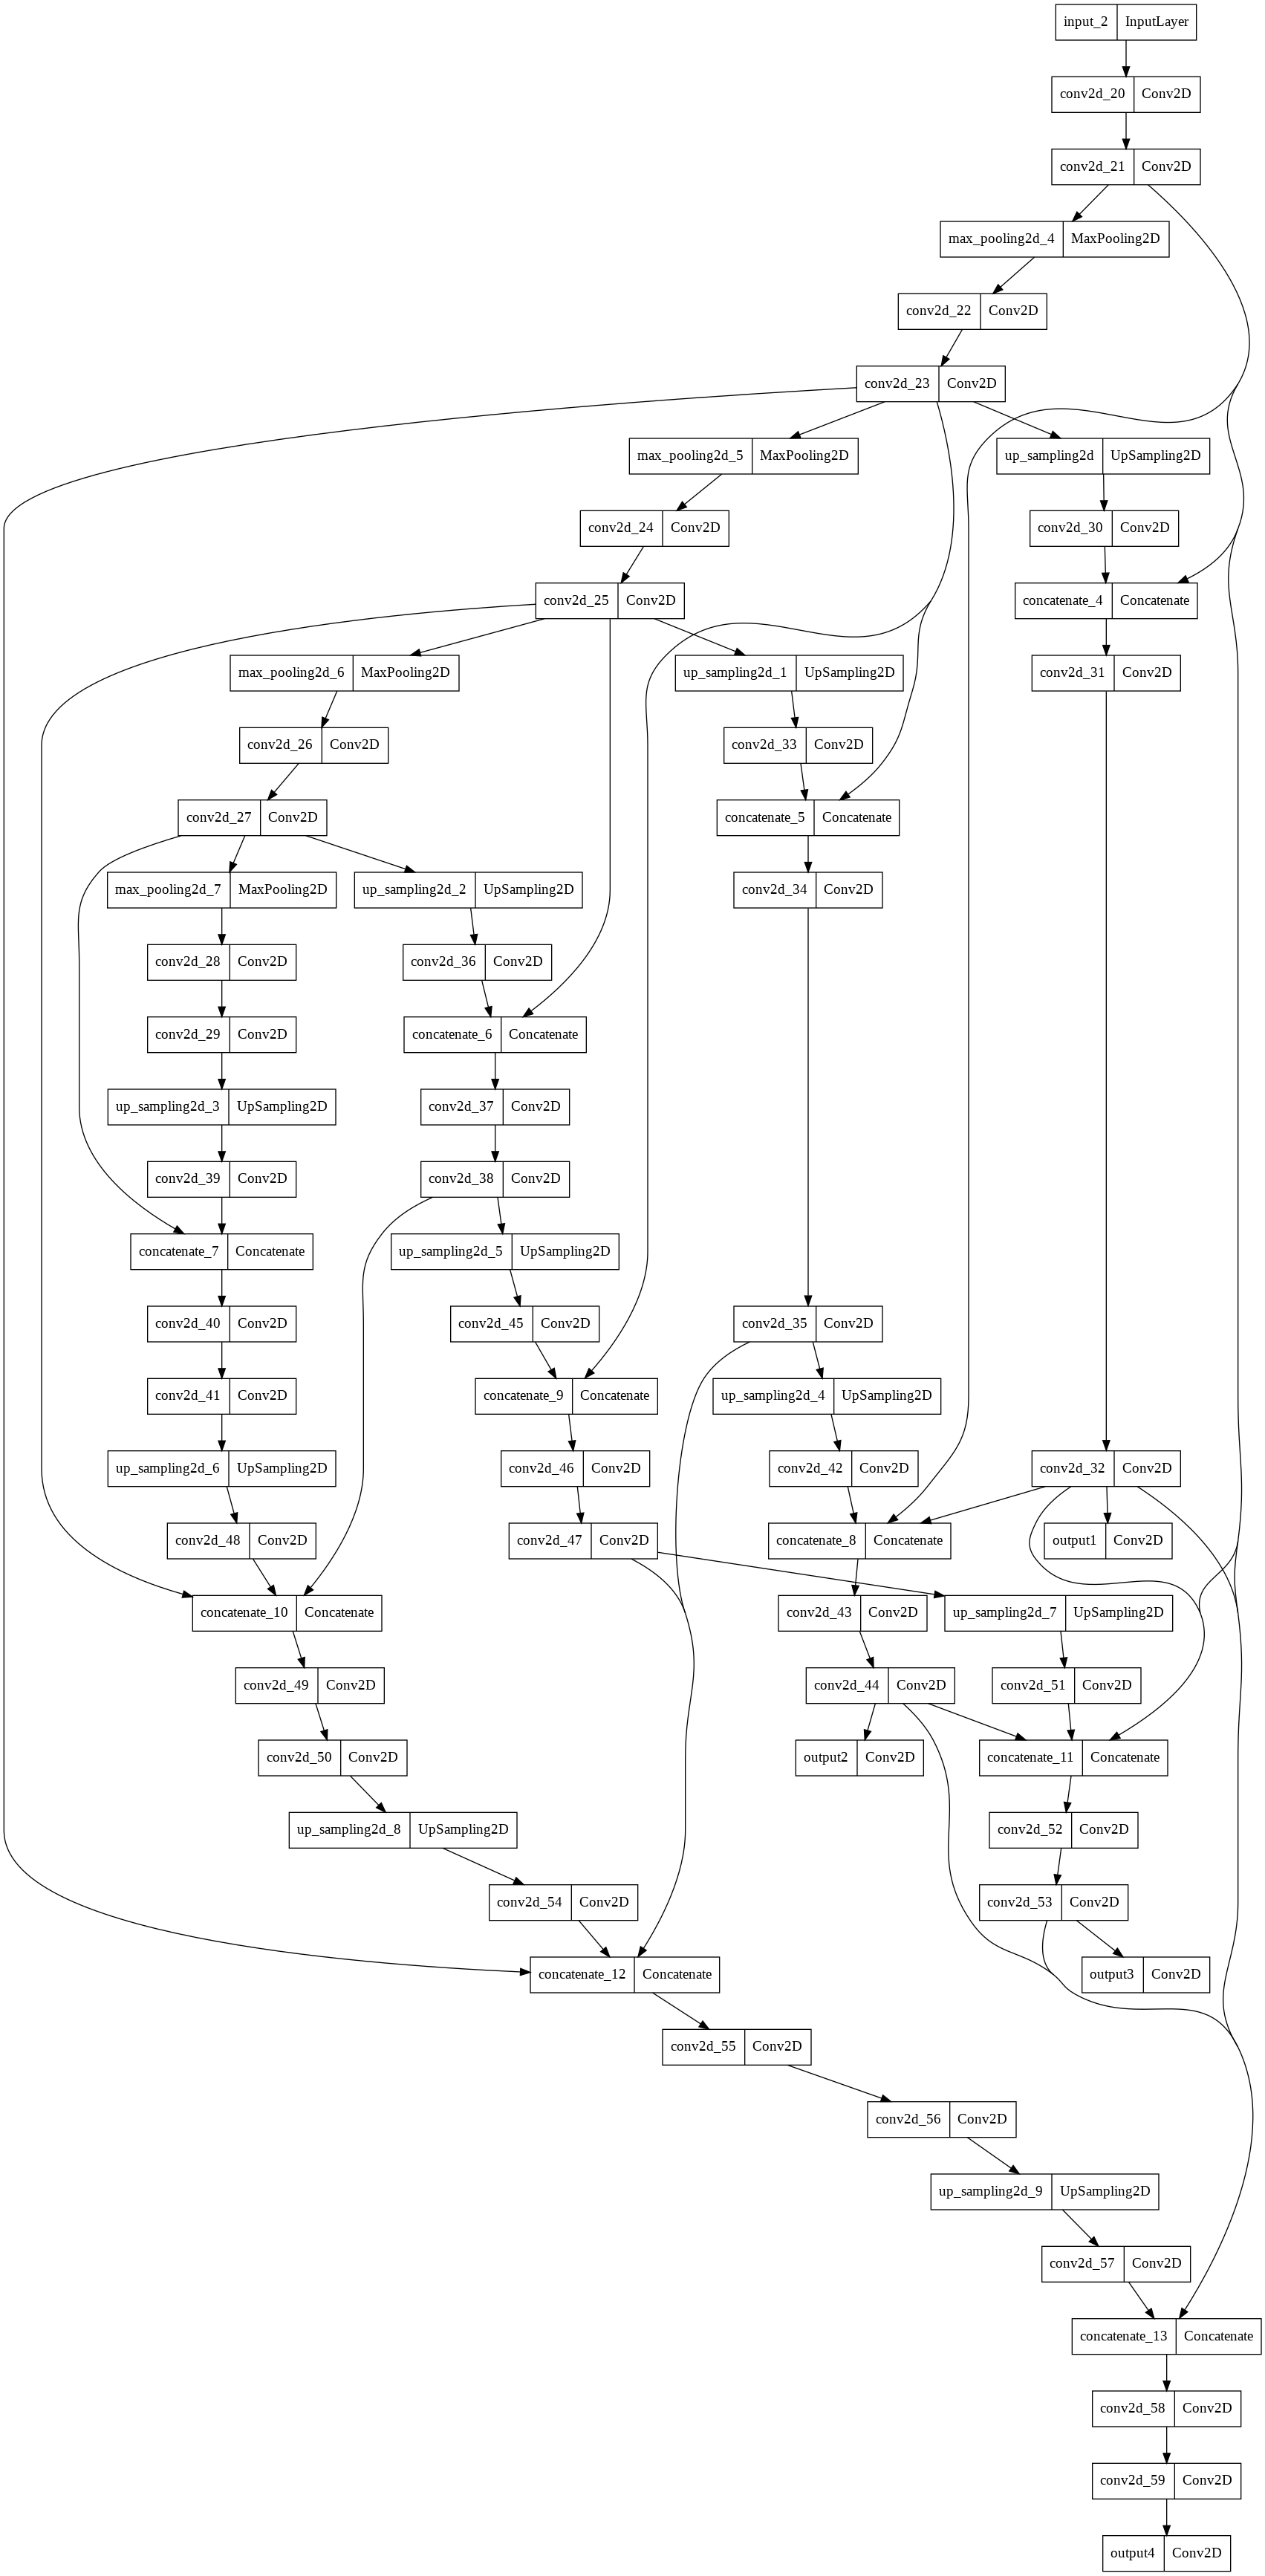

In [ ]:
tf.keras.utils.plot_model(upp_model, to_file='./upp_model.png')

In [ ]:
from keras import backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## 모델 학습하기

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/going10/testing/seg_model_unet.h5'

unet_model = Unet_build_model()
opt = tf.keras.optimizers.Adam(1e-4)
unet_model.compile(optimizer = opt, loss = 'binary_crossentropy')

unet_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 6s 358ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 4s 330ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 4s 333ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 4s 328ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 4s 327ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 4s 327ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 4s 328ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 4s 327ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 4s 327ms/step - loss: 0.6887 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 4s 328ms/step - loss: 0.6881 - val_lo

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/going10/testing/seg_model_upp.h5'

upp_model = Upp_build_model()
opt = tf.keras.optimizers.Adam(1e-4)
upp_model.compile(optimizer = opt, loss = bce_dice_loss)

upp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

upp_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 33s 1s/step - loss: 1.2654 - output1_loss: 0.3163 - output2_loss: 0.3161 - output3_loss: 0.3144 - output4_loss: 0.3187 - val_loss: 1.2012 - val_output1_loss: 0.3033 - val_output2_loss: 0.3036 - val_output3_loss: 0.2995 - val_output4_loss: 0.2948
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 1.0852 - output1_loss: 0.2932 - output2_loss: 0.2866 - output3_loss: 0.2680 - output4_loss: 0.2374 - val_loss: 0.7224 - val_output1_loss: 0.2857 - val_output2_loss: 0.2527 - val_output3_loss: 0.1679 - val_output4_loss: 0.0160
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: 0.0376 - output1_loss: 0.2767 - output2_loss: 0.1478 - output3_loss: -0.1296 - output4_loss: -0.2573 - val_loss: -0.3520 - val_output1_loss: 0.2356 - val_output2_loss: -0.1057 - val_output3_loss: -0.3170 - val_output4_loss: -0.1649
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: -0.8756 - output1_loss: 

## 시맨틱 세그멘테이션 모델 시각화

In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/going10/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

In [ ]:
upp_model_path = '/content/drive/MyDrive/aiffel/going10/testing/seg_model_upp.h5' 

upp_model = tf.keras.models.load_model(upp_model_path, compile=False)

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     prediction = output/255   # 도로로 판단한 영역
    
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()   # 도로로 판단한 영역을 시각화!
     
     if label_path:   
         label_img = imread(label_path)
         label_data = {"image":label_img}
         label_processed = preproc(**label_data)
         label_processed = label_processed["image"]
         target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

         return output, prediction, target
     else:
         return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_unet_pp, prediction_unet_pp, target_unet_pp = get_output(
    upp_model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': dir_path + f'/unet++_result_{str(i).zfill(3)}_detect.png',
                      'blend': dir_path + f'/unet++_result_{str(i).zfill(3)}_blend.png',
                      'all': dir_path + f'/unet++_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',

)

TypeError: ignored

# 회고

* upp모델을 사진을 보고 만들어 본것에 만족 하기로 했다.
* unet 기본 모델의 IoU값이 0으로 계속나와 만지다가 더 값이 이상하게 변해서 결국 노드에 있는 학습된 모델로 IoU를 출력했다. upp은 loss를 bce_dice_loss로 넣어서 실행을 하려 하였지만 학습시 loss -값이 나오는 등의 오류로 실패